In [20]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("encoded_data_final_tf_idftarget1.csv")
df.drop(columns=["Unnamed: 0","population","NCT Number"], inplace=True, errors="ignore")

In [ ]:
#csv download karke raklo : 60 - 20 - 20, features in teeno similar hone chahahiye

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target column
label_encoder = LabelEncoder()
df['Study Status'] = label_encoder.fit_transform(df['Study Status'])  # Converts COMPLETED (1), NON COMPLETED (0)

X = df.drop(columns=['Study Status'])
y = df['Study Status']

# Step 1: Split into 60% training and 40% temporary data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Step 2: Split temporary data into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print dataset shapes
print(f"\n✅ Data Split Done: X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")



✅ Data Split Done: X_train: (154545, 1314), X_val: (51515, 1314), X_test: (51516, 1314)


In [3]:
# Save datasets to CSV
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)


In [22]:
# Clean column names (to avoid errors with special characters)
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_val.columns = X_val.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns (if any)
print(f"Number of unique columns: {len(set(X_train.columns))}")
print(f"Total columns in X_train: {X_train.shape[1]}")
print("\nDuplicate Columns:")
print(X_train.columns[X_train.columns.duplicated()])

Number of unique columns: 1314
Total columns in X_train: 1314

Duplicate Columns:
Index([], dtype='object')


In [23]:
# Apply LightGBM model
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train, y_train)

# Feature importance for LightGBM
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\n🎯 Top 20 Important Features (LightGBM):")
print(feature_importance_df.head(20))

[LightGBM] [Info] Number of positive: 132745, number of negative: 21800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.587818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 235252
[LightGBM] [Info] Number of data points in the train set: 154545, number of used features: 1308
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.858941 -> initscore=1.806520
[LightGBM] [Info] Start training from score 1.806520

🎯 Top 20 Important Features (LightGBM):
                                        feature  importance
1                                    Conditions         374
5                                    Enrollment         369
2                                 Interventions         363
4                                        Phases         115
270                                    duration         107
278   Study_Design_Intervention_Model__PARALLEL          72
225                       reason_90_100_p

In [24]:
# Select features contributing to 95% importance
feature_importance_df["cumulative_importance"] = (
    feature_importance_df["importance"].cumsum() / feature_importance_df["importance"].sum()
)
selected_features = feature_importance_df[feature_importance_df["cumulative_importance"] <= 0.95]["feature"].tolist()

X_train_reduced = X_train[selected_features]
X_val_reduced = X_val[selected_features]
X_test_reduced = X_test[selected_features]

print(f"\n✔ Selected {len(selected_features)} features contributing to 95% importance.")
                                                            


✔ Selected 234 features contributing to 95% importance.


In [25]:

# Now, drop unwanted features directly from X_train_reduced and X_val_reduced
features_to_drop = [
    "TFIDF_secondaryoutcomes_due","TFIDF_primaryoutcomes_higher","TFIDF_secondaryoutcomes_life","TFIDF_criteria_allowed",
    "TFIDF_criteria_mass","TFIDF_criteria_study", "TFIDF_criteria_within", "TFIDF_criteria_patient",
    "TFIDF_summary_patient", "TFIDF_summary_treatment", "TFIDF_criteria_must",
    "TFIDF_secondaryoutcomes_day", "TFIDF_secondaryoutcomes_time",
    "TF_IDF_secondaryoutcomes_patient", "TF_IDF_criteria_week",
    "TF_IDF_criteria_active", "TF_IDF_criteria_following", "TF_IDF_criteria_time",
    "TFIDF_criteria_participate", "TFIDF_criteria_defined", "TFIDF_title_treatment",
    "TF_IDF_criteria_may", "TFIDF_primaryoutcomes_scale", "TFIDF_primaryoutcomes_patient",
    "TFIDF_secondaryoutcomes_study", "TFIDF_primaryoutcomes_number",
    "TFIDF_primaryoutcomes_defined", "TFIDF_secondaryoutcomes_scale",
    "TFIDF_secondaryoutcomes_event", "TF_IDF_criteria_enrollment",
    "TFIDF_criteria_criterion", "TFIDF_criteria_inclusion", "TFIDF_criteria_known",
    "TFIDF_criteria_prior", "TFIDF_criteria_authorized", "TFIDF_criteria_day",
    "TFIDF_criteria_randomization", "TFIDF_criteria_problem", "TFIDF_criteria_failure",
    "TFIDF_criteria_evidence", "TFIDF_criteria_concurrent", "TFIDF_criteria_risk",
    "TFIDF_criteria_agent", "TFIDF_criteria_treatment", "TFIDF_criteria_measurable",
    "TFIDF_criteria_equal", "TFIDF_criteria_including", "TFIDF_criteria_interval",
    "TFIDF_criteria_subject", "TFIDF_criteria_status", "TFIDF_criteria_requiring",
    "TFIDF_criteria_opinion", "TFIDF_criteria_basal",
    "TFIDF_secondaryoutcomes_unknownmeasures", "TFIDF_secondaryoutcomes_length",
    "TFIDF_secondaryoutcomes_endpoint", "TFIDF_secondaryoutcomes_proportion",
    "TFIDF_secondaryoutcomes_hazard", "TFIDF_secondaryoutcomes_objective",
    "TFIDF_secondaryoutcomes_response", "TFIDF_secondaryoutcomes_defined",
    "TFIDF_primaryoutcomes_rate", "TFIDF_primaryoutcomes_year",
    "TFIDF_primaryoutcomes_phase", "TFIDF_primaryoutcomes_progression",
    "TFIDF_primaryoutcomes_safety", "TFIDF_primaryoutcomes_enrolled",
    "TFIDF_primaryoutcomes_efficacy", "TFIDF_primaryoutcomes_primary",
    "TFIDF_primaryoutcomes_clinical", "TFIDF_primaryoutcomes_combination",
    "TFIDF_primaryoutcomes_cmax", "TFIDF_primaryoutcomes_cause",
    "TFIDF_primaryoutcomes_area", "TFIDF_primaryoutcomes_curve",
    "TFIDF_primaryoutcomes_objective", "TFIDF_primaryoutcomes_visual",
    "TFIDF_primaryoutcomes_criterion", "TFIDF_primaryoutcomes_unknownprimarymeasures",
    "TFIDF_primaryoutcomes_intervention", "TFIDF_primaryoutcomes_absorption",
    "TFIDF_primaryoutcomes_improvement", "TFIDF_summary_standard",
    "TFIDF_summary_intervention", "TFIDF_summary_multicenter", "TFIDF_summary_program",
    "TFIDF_summary_aimed", "TFIDF_summary_safe", "TFIDF_summary_volunteer",
    "TFIDF_summary_exercise", "TFIDF_summary_spread", "TFIDF_summary_may",
    "TFIDF_summary_help", "TFIDF_summary_drug", "TFIDF_summary_cell",
    "TFIDF_summary_stage", "TFIDF_summary_progression", "TFIDF_summary_determine",
    "TFIDF_title_registry", "TFIDF_title_effect", "TFIDF_title_patient",
    "TFIDF_title_solid", "TFIDF_title_intervention", "TFIDF_title_negative",
    "TFIDF_title_healthy", "TFIDF_secondaryoutcomes_patient", "TFIDF_criteria_active",
    "TFIDF_criteria_following", "TFIDF_criteria_may", "TFIDF_criteria_week",
    "TFIDF_criteria_greater", "TFIDF_criteria_time", "TFIDF_criteria_defined"
]

# Drop the selected features directly from the datasets
X_train_reduced.drop(columns=[col for col in features_to_drop if col in X_train_reduced.columns], inplace=True)
X_val_reduced.drop(columns=[col for col in features_to_drop if col in X_val_reduced.columns], inplace=True)

# Now, X_train_reduced and X_val_reduced will have the dropped features


C:\Users\yuvik\AppData\Local\Temp\ipykernel_11744\2906290542.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced.drop(columns=[col for col in features_to_drop if col in X_train_reduced.columns], inplace=True)
C:\Users\yuvik\AppData\Local\Temp\ipykernel_11744\2906290542.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced.drop(columns=[col for col in features_to_drop if col in X_val_reduced.columns], inplace=True)


In [26]:
X_test_reduced.drop(columns=[col for col in features_to_drop if col in X_test_reduced.columns], inplace=True)

C:\Users\yuvik\AppData\Local\Temp\ipykernel_11744\2498038521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_reduced.drop(columns=[col for col in features_to_drop if col in X_test_reduced.columns], inplace=True)


In [80]:
import pandas as pd

# Save the reduced train, validation, and test datasets
train_df_reduced = pd.concat([X_train_reduced, y_train], axis=1)
val_df_reduced = pd.concat([X_val_reduced, y_val], axis=1)
test_df_reduced = pd.concat([X_test_reduced, y_test], axis=1)

train_df_reduced.to_csv("train_data_reduced.csv", index=False)
val_df_reduced.to_csv("val_data_reduced.csv", index=False)
test_df_reduced.to_csv("test_data_reduced.csv", index=False)

print("\n💾 Train, validation, and test datasets (reduced) saved as CSV!")

KeyboardInterrupt: 

In [27]:
# ✅ Check feature distribution across Train, Val, and Test sets
print("\n🔍 Checking Feature Distributions:")

train_mean = X_train_reduced.mean()
val_mean = X_val_reduced.mean()
test_mean = X_test_reduced.mean()

distribution_df = pd.DataFrame({
    "Train Mean": train_mean,
    "Validation Mean": val_mean,
    "Test Mean": test_mean
})

# Show top 20 features with distribution difference
distribution_df["Train-Val Diff"] = abs(distribution_df["Train Mean"] - distribution_df["Validation Mean"])
distribution_df["Train-Test Diff"] = abs(distribution_df["Train Mean"] - distribution_df["Test Mean"])

print("\n📊 Top 20 Feature Distribution Differences (Train vs Val & Test):")
print(distribution_df.sort_values(by=["Train-Val Diff", "Train-Test Diff"], ascending=False).head(20))


🔍 Checking Feature Distributions:

📊 Top 20 Feature Distribution Differences (Train vs Val & Test):
                                                    Train Mean  \
Phases                                                5.388295   
Funder_Type                                           5.065243   
country_Germany                                       0.057427   
country_France                                        0.071138   
country_countries_with_low_cumsum_value               0.161694   
organ_system_Gastrointestinal_disorders               0.107451   
Study_Design_Intervention_Model__CROSSOVER            0.076321   
Study_Type                                            0.205591   
Study_Design_Intervention_Model__PARALLEL             0.457802   
country_United_States                                 0.397632   
event_type_other                                      0.137216   
period_overall_study                                  0.098282   
healthy_volunteers                       

In [28]:
# Handle missing data (replace Inf and NaN values)
X_train_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train_reduced.fillna(X_train_reduced.mean(), inplace=True)
X_val_reduced.fillna(X_val_reduced.mean(), inplace=True)
X_test_reduced.fillna(X_test_reduced.mean(), inplace=True)

print("✔ Replaced Inf values and handled missing data.")

C:\Users\yuvik\AppData\Local\Temp\ipykernel_11744\2242360006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\yuvik\AppData\Local\Temp\ipykernel_11744\2242360006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\yuvik\AppData\Local\Temp\ipykernel_11744\2242360006.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

✔ Replaced Inf values and handled missing data.


In [29]:
# Apply Standard Scaling to features
scaler = StandardScaler()
X_train_reduced = pd.DataFrame(scaler.fit_transform(X_train_reduced), columns=X_train_reduced.columns)
X_val_reduced = pd.DataFrame(scaler.transform(X_val_reduced), columns=X_val_reduced.columns)
X_test_reduced = pd.DataFrame(scaler.transform(X_test_reduced), columns=X_test_reduced.columns)

print("✔ Applied Standard Scaling to Features.")

✔ Applied Standard Scaling to Features.


In [11]:
# Save the fitted scaler to a pickle file
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✔ Saved the scaler as 'scaler.pkl'.")

✔ Saved the scaler as 'scaler.pkl'.


In [30]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("\n✔ Computed Class Weights:", class_weight_dict)



✔ Computed Class Weights: {0: 3.5446100917431194, 1: 0.5821123206147124}


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)


In [86]:
# Train Logistic Regression model
log_reg = LogisticRegression(
    max_iter=500,
    solver='liblinear',
    class_weight=class_weight_dict,
    random_state=42
)
log_reg.fit(X_train_reduced, y_train)

# Predict on validation and test sets
y_pred_val = log_reg.predict(X_val_reduced)
y_pred_test = log_reg.predict(X_test_reduced)

# Evaluate model performance on validation set
y_pred_proba_val = log_reg.predict_proba(X_val_reduced)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("\n🎯 Logistic Regression Model Performance (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val:.4f}")



🎯 Logistic Regression Model Performance (Validation Set):
              precision    recall  f1-score   support

           0       0.58      0.83      0.69      7267
           1       0.97      0.90      0.94     44248

    accuracy                           0.89     51515
   macro avg       0.78      0.87      0.81     51515
weighted avg       0.92      0.89      0.90     51515

🔹 AUC-ROC (Validation Set): 0.9376


In [62]:
# Evaluate model performance on test set
y_pred_proba_test = log_reg.predict_proba(X_test_reduced)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("\n🎯 Logistic Regression Model Performance (Test Set):")
print(classification_report(y_test, y_pred_test))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test:.4f}")


🎯 Logistic Regression Model Performance (Test Set):
              precision    recall  f1-score   support

           0       0.59      0.83      0.69      7267
           1       0.97      0.90      0.94     44249

    accuracy                           0.89     51516
   macro avg       0.78      0.87      0.81     51516
weighted avg       0.92      0.89      0.90     51516

🔹 AUC-ROC (Test Set): 0.9392


In [32]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight= y_train.value_counts()[0] / y_train.value_counts()[1]
)

xgb_model.fit(X_train_reduced, y_train)

# Predict on validation and test sets
y_pred_val = xgb_model.predict(X_val_reduced)
y_pred_test = xgb_model.predict(X_test_reduced)

# Evaluate model performance on validation set
y_pred_proba_val = xgb_model.predict_proba(X_val_reduced)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("\n🎯 XGBoost Model Performance (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val:.4f}")


🎯 XGBoost Model Performance (Validation Set):
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      7267
           1       0.97      0.94      0.96     44248

    accuracy                           0.92     51515
   macro avg       0.83      0.88      0.85     51515
weighted avg       0.93      0.92      0.93     51515

🔹 AUC-ROC (Validation Set): 0.9587


In [33]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on training set
y_pred_train = xgb_model.predict(X_train_reduced)
y_pred_proba_train = xgb_model.predict_proba(X_train_reduced)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)

# Predict on validation set
y_pred_val = xgb_model.predict(X_val_reduced)
y_pred_proba_val = xgb_model.predict_proba(X_val_reduced)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

# Print classification report and AUC-ROC for training set
print("\n🎯 XGBoost Model Performance (Training Set):")
print(classification_report(y_train, y_pred_train))
print(f"🔹 AUC-ROC (Training Set): {roc_auc_train:.4f}")

# Print classification report and AUC-ROC for validation set
print("\n🎯 XGBoost Model Performance (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val:.4f}")



🎯 XGBoost Model Performance (Training Set):
              precision    recall  f1-score   support

           0       0.78      0.92      0.85     21800
           1       0.99      0.96      0.97    132745

    accuracy                           0.95    154545
   macro avg       0.89      0.94      0.91    154545
weighted avg       0.96      0.95      0.95    154545

🔹 AUC-ROC (Training Set): 0.9877

🎯 XGBoost Model Performance (Validation Set):
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      7267
           1       0.97      0.94      0.96     44248

    accuracy                           0.92     51515
   macro avg       0.83      0.88      0.85     51515
weighted avg       0.93      0.92      0.93     51515

🔹 AUC-ROC (Validation Set): 0.9587


In [34]:
# Evaluate model performance on test set
y_pred_proba_test = xgb_model.predict_proba(X_test_reduced)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("\n🎯 XGBoost Model Performance (Test Set):")
print(classification_report(y_test, y_pred_test))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test:.4f}")


🎯 XGBoost Model Performance (Test Set):
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      7267
           1       0.97      0.94      0.96     44249

    accuracy                           0.92     51516
   macro avg       0.83      0.87      0.85     51516
weighted avg       0.93      0.92      0.93     51516

🔹 AUC-ROC (Test Set): 0.9577


In [105]:
import pickle

# Save the trained XGBoost model to a pickle file
with open('xgb_model.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)

print("🎯 XGBoost model saved to 'xgb_model.pkl'")


🎯 XGBoost model saved to 'xgb_model.pkl'


In [67]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Load the X_test data (already preprocessed and reduced)
x_test_val_df = pd.read_csv('test_data_reduced.csv')  # Replace with your actual CSV file path

# Extract true labels
y_true_new_data = x_test_val_df['Study Status']  # Replace with the correct column name if needed
X_test_reduced = x_test_val_df.drop(columns=['Study Status'])  # Drop target column from features

# Handle missing data (replace Inf and NaN values)
X_test_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_reduced.fillna(X_test_reduced.mean(), inplace=True)

print("✔ Replaced Inf values and handled missing data.")

# Load the trained StandardScaler used during training
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Apply the same Standard Scaling transformation
X_test_reduced = pd.DataFrame(scaler.transform(X_test_reduced), columns=X_test_reduced.columns)

print("✔ Applied Standard Scaling to Features.")

# Load the trained XGBoost model from pickle file
with open('xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

# Predict on the new data
y_pred_new_data = xgb_model.predict(X_test_reduced)  # Predict the class labels
y_pred_proba_new_data = xgb_model.predict_proba(X_test_reduced)[:, 1]  # Predict probabilities for AUC

# Evaluate model performance on the new data
accuracy = accuracy_score(y_true_new_data, y_pred_new_data)
roc_auc_new_data = roc_auc_score(y_true_new_data, y_pred_proba_new_data)

# Print evaluation metrics
print(f"🎯 Accuracy on the new data: {accuracy:.4f}")
print("\n🎯 Classification Report on the new data:")
print(classification_report(y_true_new_data, y_pred_new_data))
print(f"🔹 AUC-ROC on the new data: {roc_auc_new_data:.4f}")

# Optionally, save predictions to a CSV file
predictions_df = pd.DataFrame({'Predicted': y_pred_new_data, 'Probability': y_pred_proba_new_data})
predictions_df.to_csv('predictions_on_new_data.csv', index=False)

# Print first few predictions
print(predictions_df.head())


✔ Replaced Inf values and handled missing data.
✔ Applied Standard Scaling to Features.
🎯 Accuracy on the new data: 0.9244

🎯 Classification Report on the new data:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      7267
           1       0.97      0.94      0.96     44249

    accuracy                           0.92     51516
   macro avg       0.83      0.87      0.85     51516
weighted avg       0.93      0.92      0.93     51516

🔹 AUC-ROC on the new data: 0.9577
   Predicted  Probability
0          0     0.220974
1          1     0.997394
2          1     0.999803
3          1     0.995838
4          0     0.013547


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_proba_test = xgb_model.predict_proba(X_test_reduced)[:, 1] 
y_pred_test = xgb_model.predict(X_test_reduced) 

roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("\n🎯 XGBoost Model Performance (Test Set):")
print(classification_report(y_test, y_pred_test))  
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test:.4f}")

print("\n📝 Sample Inputs and Predictions:")
num_samples = 50
for i in range(num_samples):
    print(f"\nExample {i+1}:")
    print(f"Input Features: {X_test_reduced.iloc[i].values}")
    
    print(f"Actual Label: {y_test.iloc[i]}")
    
    print(f"Predicted Label: {y_pred_test[i]}")
    
    print(f"Predicted Probability (Positive Class): {y_pred_proba_test[i]:.4f}")


🎯 XGBoost Model Performance (Test Set):
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      3634
           1       0.97      0.94      0.95     22124

    accuracy                           0.92     25758
   macro avg       0.83      0.88      0.85     25758
weighted avg       0.93      0.92      0.93     25758

🔹 AUC-ROC (Test Set): 0.9598

📝 Sample Inputs and Predictions:

Example 1:
Input Features: [ 0.25814246 -0.53715217 -0.0111203   0.73342263  0.45012499  1.09008556
 -0.16476042 -0.02226977 -0.16746619 -0.81045532  0.65017474 -0.12585517
 -0.27173928 -0.28826288  0.9481445  -0.50024264 -0.0834951  -0.3253968
  1.52825211 -0.17594837 -0.19328855 -0.18912567 -0.15319025  0.58301276
 -0.08707211 -0.12463174 -0.04912265 -0.24129786 -0.23919694 -0.10766457
 -0.44639818 -0.11631263 -0.25043563 -0.10898402 -0.11596955 -0.52551515
 -0.08106162 -0.19789571 -0.12495753 -0.04521166 -0.14837669 -0.09800683
 -0.12451548 -0.34291938 -0.061

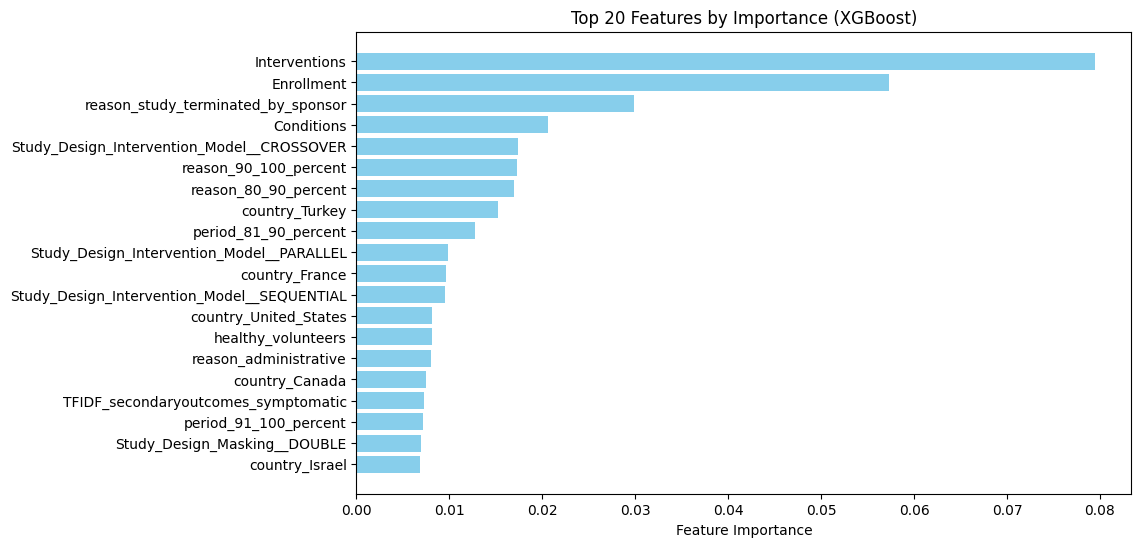


📊 Top 20 Features by Importance:
                                    Feature  Importance
                              Interventions    0.079429
                                 Enrollment    0.057274
         reason_study_terminated_by_sponsor    0.029829
                                 Conditions    0.020659
 Study_Design_Intervention_Model__CROSSOVER    0.017342
                      reason_90_100_percent    0.017246
                       reason_80_90_percent    0.016938
                             country_Turkey    0.015204
                       period_81_90_percent    0.012739
  Study_Design_Intervention_Model__PARALLEL    0.009847
                             country_France    0.009683
Study_Design_Intervention_Model__SEQUENTIAL    0.009540
                      country_United_States    0.008141
                         healthy_volunteers    0.008096
                      reason_administrative    0.008030
                             country_Canada    0.007449
        TFIDF_

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance (XGBoost)')
plt.gca().invert_yaxis()  
plt.show()

print("\n📊 Top 20 Features by Importance:")
print(top_features.to_string(index=False))  


In [69]:
# Get the top 10 features based on importance
top_10_features = feature_importance_df.head(10)['Feature'].tolist()

# Print the top 10 features
print("\n📊 Top 10 Features by Importance:")
print(top_10_features)

# Select only the top 10 features from the training, validation, and test sets
X_train_top10 = X_train_reduced[top_10_features]
X_val_top10 = X_val_reduced[top_10_features]
X_test_top10 = X_test_reduced[top_10_features]

# Train the XGBoost model on the top 10 features
xgb_model_top10 = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]
)

xgb_model_top10.fit(X_train_top10, y_train)

# Predict on validation and test sets with the new model
y_pred_val_top10 = xgb_model_top10.predict(X_val_top10)
y_pred_test_top10 = xgb_model_top10.predict(X_test_top10)

# Evaluate model performance on validation set
y_pred_proba_val_top10 = xgb_model_top10.predict_proba(X_val_top10)[:, 1]
roc_auc_val_top10 = roc_auc_score(y_val, y_pred_proba_val_top10)

print("\n🎯 XGBoost Model Performance on Top 10 Features (Validation Set):")
print(classification_report(y_val, y_pred_val_top10))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val_top10:.4f}")

# Evaluate model performance on test set
y_pred_proba_test_top10 = xgb_model_top10.predict_proba(X_test_top10)[:, 1]
roc_auc_test_top10 = roc_auc_score(y_test, y_pred_proba_test_top10)

print("\n🎯 XGBoost Model Performance on Top 10 Features (Test Set):")
print(classification_report(y_test, y_pred_test_top10))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test_top10:.4f}")



📊 Top 10 Features by Importance:
['Interventions', 'Enrollment', 'reason_study_terminated_by_sponsor', 'Conditions', 'Study_Design_Intervention_Model__CROSSOVER', 'reason_90_100_percent', 'reason_80_90_percent', 'country_Turkey', 'period_81_90_percent', 'Study_Design_Intervention_Model__PARALLEL']

🎯 XGBoost Model Performance on Top 10 Features (Validation Set):
              precision    recall  f1-score   support

           0       0.65      0.81      0.72      7267
           1       0.97      0.93      0.95     44248

    accuracy                           0.91     51515
   macro avg       0.81      0.87      0.83     51515
weighted avg       0.92      0.91      0.92     51515

🔹 AUC-ROC (Validation Set): 0.9485

🎯 XGBoost Model Performance on Top 10 Features (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.81      0.72      7267
           1       0.97      0.93      0.95     44249

    accuracy                           0.91     

In [36]:
# Get the top 5 features based on importance
top_5_features = feature_importance_df.head(5)['Feature'].tolist()

# Print the top 5 features
print("\n📊 Top 5 Features by Importance:")
print(top_5_features)

# Select only the top 5 features from the training, validation, and test sets
X_train_top5 = X_train_reduced[top_5_features]
X_val_top5 = X_val_reduced[top_5_features]
X_test_top5 = X_test_reduced[top_5_features]

# Train the XGBoost model on the top 5 features
xgb_model_top5 = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]
)

xgb_model_top5.fit(X_train_top5, y_train)

# Predict on validation and test sets with the new model
y_pred_val_top5 = xgb_model_top5.predict(X_val_top5)
y_pred_test_top5 = xgb_model_top5.predict(X_test_top5)

# Evaluate model performance on validation set
y_pred_proba_val_top5 = xgb_model_top5.predict_proba(X_val_top5)[:, 1]
roc_auc_val_top5 = roc_auc_score(y_val, y_pred_proba_val_top5)

print("\n🎯 XGBoost Model Performance on Top 5 Features (Validation Set):")
print(classification_report(y_val, y_pred_val_top5))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val_top5:.4f}")

# Evaluate model performance on test set
y_pred_proba_test_top5 = xgb_model_top5.predict_proba(X_test_top5)[:, 1]
roc_auc_test_top5 = roc_auc_score(y_test, y_pred_proba_test_top5)

print("\n🎯 XGBoost Model Performance on Top 5 Features (Test Set):")
print(classification_report(y_test, y_pred_test_top5))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test_top5:.4f}")


📊 Top 5 Features by Importance:
['Interventions', 'Enrollment', 'reason_study_terminated_by_sponsor', 'Conditions', 'Study_Design_Intervention_Model__CROSSOVER']

🎯 XGBoost Model Performance on Top 5 Features (Validation Set):
              precision    recall  f1-score   support

           0       0.63      0.80      0.71      7267
           1       0.97      0.92      0.94     44248

    accuracy                           0.91     51515
   macro avg       0.80      0.86      0.83     51515
weighted avg       0.92      0.91      0.91     51515

🔹 AUC-ROC (Validation Set): 0.9445

🎯 XGBoost Model Performance on Top 5 Features (Test Set):
              precision    recall  f1-score   support

           0       0.64      0.80      0.71      7267
           1       0.97      0.92      0.94     44249

    accuracy                           0.91     51516
   macro avg       0.80      0.86      0.83     51516
weighted avg       0.92      0.91      0.91     51516

🔹 AUC-ROC (Test Set): 0.

In [37]:
import pickle

# Assuming `X_train_top5.columns` contains the selected top 5 feature names
selected_features = list(X_train_top5.columns)

# Save the feature names used in training
with open("training_features.pkl", "wb") as f:
    pickle.dump(selected_features, f)


In [19]:
# Save the test data with the top 5 features to a CSV file
X_test_top5.to_csv('X_test_top5_features.csv', index=False)

print("✔ Test data with top 5 features saved as 'X_test_top5_features.csv'.")


✔ Test data with top 5 features saved as 'X_test_top5_features.csv'.


In [109]:
import pickle

# Save the model to a pickle file
with open('xgb_model_top5.pkl', 'wb') as f:
    pickle.dump(xgb_model_top5, f)

print("✔ XGBoost model on top 5 features saved successfully.")


✔ XGBoost model on top 5 features saved successfully.


testing a new code for better 0 precision

In [71]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# 1. Adjust class weights more aggressively
def train_weighted_model(X_train, y_train, X_val, y_val, X_test, y_test, weight_ratio=2.0):
    xgb_model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,  # Slightly reduced to prevent overfitting
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=weight_ratio * (y_train.value_counts()[0] / y_train.value_counts()[1]),
        min_child_weight=3,  # Added to help with precision
        gamma=1  # Added to make splits more conservative
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_val = xgb_model.predict(X_val)
    y_pred_test = xgb_model.predict(X_test)
    
    # Print results
    print(f"\nResults with weight_ratio = {weight_ratio}:")
    print("\nValidation Set:")
    print(classification_report(y_val, y_pred_val))
    print("\nTest Set:")
    print(classification_report(y_test, y_pred_test))
    
    return xgb_model

# 2. Probability threshold tuning
def find_optimal_threshold(model, X_val, y_val, target_recall=0.80):
    probabilities = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_f1 = 0
    best_precision = 0
    
    for threshold in thresholds:
        predictions = (probabilities < threshold).astype(int)  # Note: inverting threshold for class 0
        
        # Calculate metrics for class 0
        true_pos = sum((predictions == 0) & (y_val == 0))
        false_pos = sum((predictions == 0) & (y_val == 1))
        false_neg = sum((predictions == 1) & (y_val == 0))
        
        recall = true_pos / (true_pos + false_neg)
        if recall >= target_recall:  # Only consider thresholds that maintain target recall
            precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            if precision > best_precision:
                best_precision = precision
                best_threshold = threshold
                best_f1 = f1
    
    return best_threshold

# 3. Train and evaluate model with optimized parameters
def train_optimized_model(X_train, y_train, X_val, y_val, X_test, y_test):
    # First train with adjusted weights
    model = train_weighted_model(X_train, y_train, X_val, y_val, X_test, y_test, weight_ratio=2.0)
    
    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(model, X_val, y_val, target_recall=0.80)
    print(f"\nOptimal threshold: {optimal_threshold}")
    
    # Make predictions with optimal threshold
    def predict_with_threshold(model, X, threshold):
        probabilities = model.predict_proba(X)[:, 1]
        return (probabilities < threshold).astype(int)
    
    # Final predictions
    y_pred_val = predict_with_threshold(model, X_val, optimal_threshold)
    y_pred_test = predict_with_threshold(model, X_test, optimal_threshold)
    
    print("\nFinal Results with Optimal Threshold:")
    print("\nValidation Set:")
    print(classification_report(y_val, y_pred_val))
    print("\nTest Set:")
    print(classification_report(y_test, y_pred_test))
    
    return model, optimal_threshold

# Use the functions
model, threshold = train_optimized_model(X_train_top5, y_train, X_val_top5, y_val, X_test_top5, y_test)


Results with weight_ratio = 2.0:

Validation Set:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      7267
           1       0.96      0.96      0.96     44248

    accuracy                           0.93     51515
   macro avg       0.87      0.86      0.86     51515
weighted avg       0.93      0.93      0.93     51515


Test Set:
              precision    recall  f1-score   support

           0       0.77      0.74      0.76      7267
           1       0.96      0.96      0.96     44249

    accuracy                           0.93     51516
   macro avg       0.87      0.85      0.86     51516
weighted avg       0.93      0.93      0.93     51516


Optimal threshold: 0.5

Final Results with Optimal Threshold:

Validation Set:
              precision    recall  f1-score   support

           0       0.04      0.25      0.07      7267
           1       0.22      0.04      0.06     44248

    accuracy                           0

In [111]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np

# Get the top 5 features based on importance
top_5_features_opt = feature_importance_df.head(5)['Feature'].tolist()

# Print the top 5 features
print("\n📊 Top 5 Features by Importance:")
print(top_5_features_opt)

# Select only the top 5 features from the training, validation, and test sets
X_train_top5_opt = X_train_reduced[top_5_features_opt]
X_val_top5_opt = X_val_reduced[top_5_features_opt]
X_test_top5_opt = X_test_reduced[top_5_features_opt]

# Train the XGBoost model on the top 5 features with optimized weight_ratio
xgb_model_top5_opt = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=2.0 * (y_train.value_counts()[0] / y_train.value_counts()[1]),
    min_child_weight=3,
    gamma=1
)

# Fit the model
xgb_model_top5_opt.fit(X_train_top5_opt, y_train)

# Predict on training, validation, and test sets
y_pred_train_top5_opt = xgb_model_top5_opt.predict(X_train_top5_opt)
y_pred_val_top5_opt = xgb_model_top5_opt.predict(X_val_top5_opt)
y_pred_test_top5_opt = xgb_model_top5_opt.predict(X_test_top5_opt)

# Get probability predictions for ROC-AUC calculation
y_pred_proba_train_top5_opt = xgb_model_top5_opt.predict_proba(X_train_top5_opt)[:, 1]
y_pred_proba_val_top5_opt = xgb_model_top5_opt.predict_proba(X_val_top5_opt)[:, 1]
y_pred_proba_test_top5_opt = xgb_model_top5_opt.predict_proba(X_test_top5_opt)[:, 1]

# Calculate ROC-AUC scores
roc_auc_train_top5_opt = roc_auc_score(y_train, y_pred_proba_train_top5_opt)
roc_auc_val_top5_opt = roc_auc_score(y_val, y_pred_proba_val_top5_opt)
roc_auc_test_top5_opt = roc_auc_score(y_test, y_pred_proba_test_top5_opt)

# Print model performance metrics
print("\n🎯 XGBoost Model Performance on Top 5 Features (Training Set):")
print(classification_report(y_train, y_pred_train_top5_opt))
print(f"🔹 AUC-ROC (Training Set): {roc_auc_train_top5_opt:.4f}")

print("\n🎯 XGBoost Model Performance on Top 5 Features (Validation Set):")
print(classification_report(y_val, y_pred_val_top5_opt))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val_top5_opt:.4f}")

print("\n🎯 XGBoost Model Performance on Top 5 Features (Test Set):")
print(classification_report(y_test, y_pred_test_top5_opt))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test_top5_opt:.4f}")

# Calculate and display feature importance for the top 5 features
feature_importance_opt = xgb_model_top5_opt.feature_importances_
feature_importance_df_top5_opt = pd.DataFrame({
    'Feature': top_5_features_opt,
    'Importance': feature_importance_opt
})
feature_importance_df_top5_opt = feature_importance_df_top5_opt.sort_values('Importance', ascending=False)

print("\n📊 Feature Importance for Top 5 Features:")
print(feature_importance_df_top5_opt)

# Save the model (optional)
xgb_model_top5_opt.save_model('xgboost_top5_optimized_v2.model')



📊 Top 5 Features by Importance:
['Interventions', 'Enrollment', 'reason_study_terminated_by_sponsor', 'Conditions', 'Study_Design_Intervention_Model__CROSSOVER']

🎯 XGBoost Model Performance on Top 5 Features (Training Set):
              precision    recall  f1-score   support

           0       0.80      0.77      0.79     21800
           1       0.96      0.97      0.97    132745

    accuracy                           0.94    154545
   macro avg       0.88      0.87      0.88    154545
weighted avg       0.94      0.94      0.94    154545

🔹 AUC-ROC (Training Set): 0.9637

🎯 XGBoost Model Performance on Top 5 Features (Validation Set):
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      7267
           1       0.96      0.96      0.96     44248

    accuracy                           0.93     51515
   macro avg       0.87      0.86      0.86     51515
weighted avg       0.93      0.93      0.93     51515

🔹 AUC-ROC (Validation 

In [53]:
import optuna
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1]  # Keep this fixed
    }
    
    # Create and train model
    model = xgb.XGBClassifier(
        **params,
        random_state=42
    )
    
    model.fit(X_train_top5, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val_top5)
    
    # Calculate metrics
    precision = precision_score(y_val, y_pred)
    current_recall = recall_score(y_val, y_pred)
    baseline_recall = recall_score(y_val, y_pred_val_top5)  # Your original recall
    
    # Penalty if recall drops too much (more than 5% from baseline)
    recall_penalty = max(0, (baseline_recall - current_recall - 0.05)) * 10
    
    # Objective: Maximize precision while maintaining recall
    return -precision + recall_penalty  # Negative because Optuna minimizes

# Create study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get best parameters
best_params = study.best_params
print("\n🔍 Best Parameters Found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Train model with best parameters
best_model = xgb.XGBClassifier(
    **best_params,
    random_state=42,
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]
)

best_model.fit(X_train_top5, y_train)

# Evaluate on validation set
y_pred_val_tuned = best_model.predict(X_val_top5)
y_pred_proba_val_tuned = best_model.predict_proba(X_val_top5)[:, 1]
roc_auc_val_tuned = roc_auc_score(y_val, y_pred_proba_val_tuned)

print("\n🎯 Tuned XGBoost Model Performance (Validation Set):")
print(classification_report(y_val, y_pred_val_tuned))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val_tuned:.4f}")

# Evaluate on test set
y_pred_test_tuned = best_model.predict(X_test_top5)
y_pred_proba_test_tuned = best_model.predict_proba(X_test_top5)[:, 1]
roc_auc_test_tuned = roc_auc_score(y_test, y_pred_proba_test_tuned)

print("\n🎯 Tuned XGBoost Model Performance (Test Set):")
print(classification_report(y_test, y_pred_test_tuned))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test_tuned:.4f}")

# Compare with original model
print("\n📊 Performance Comparison:")
print("Original Model:")
print(f"Precision: {precision_score(y_val, y_pred_val_top5):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_val_top5):.4f}")
print("\nTuned Model:")
print(f"Precision: {precision_score(y_val, y_pred_val_tuned):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_val_tuned):.4f}")

[I 2025-02-15 01:43:52,159] A new study created in memory with name: no-name-651e3a32-dd96-4386-991a-0da590fb7602
[I 2025-02-15 01:44:02,194] Trial 0 finished with value: -0.9689432063263839 and parameters: {'n_estimators': 141, 'max_depth': 11, 'learning_rate': 0.13678548889846046, 'subsample': 0.6430284143517218, 'colsample_bytree': 0.853200995004155, 'min_child_weight': 2, 'gamma': 4.295014206841673}. Best is trial 0 with value: -0.9689432063263839.
[I 2025-02-15 01:44:33,411] Trial 1 finished with value: -0.9679052440538733 and parameters: {'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.11642810509382383, 'subsample': 0.962157900061356, 'colsample_bytree': 0.8445908134927397, 'min_child_weight': 6, 'gamma': 0.36311135800501493}. Best is trial 0 with value: -0.9689432063263839.
[I 2025-02-15 01:45:23,749] Trial 2 finished with value: -0.9669543655524295 and parameters: {'n_estimators': 554, 'max_depth': 12, 'learning_rate': 0.06344153416833942, 'subsample': 0.67073449048589

KeyboardInterrupt: 

In [23]:
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X_train_reduced.columns[:len(importances)],  # Match length of features
    "Importance": importances
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

N = 10
top_n_features = feature_importance_df["Feature"].head(N).tolist()

X_train_top_features = X_train_reduced[top_n_features]
X_val_top_features = X_val_reduced[top_n_features]
X_test_top_features = X_test_reduced[top_n_features]

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight= y_train.value_counts()[0] / y_train.value_counts()[1]
)

xgb_model.fit(X_train_top_features, y_train)

y_pred_val = xgb_model.predict(X_val_top_features)
y_pred_test = xgb_model.predict(X_test_top_features)

y_pred_proba_val = xgb_model.predict_proba(X_val_top_features)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("\n🎯 XGBoost Model Performance (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val:.4f}")

y_pred_proba_test = xgb_model.predict_proba(X_test_top_features)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("\n🎯 XGBoost Model Performance (Test Set):")
print(classification_report(y_test, y_pred_test))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test:.4f}")



🎯 XGBoost Model Performance (Validation Set):
              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3633
           1       0.97      0.92      0.95     22125

    accuracy                           0.91     25758
   macro avg       0.80      0.87      0.83     25758
weighted avg       0.92      0.91      0.91     25758

🔹 AUC-ROC (Validation Set): 0.9495

🎯 XGBoost Model Performance (Test Set):
              precision    recall  f1-score   support

           0       0.64      0.81      0.72      3634
           1       0.97      0.93      0.95     22124

    accuracy                           0.91     25758
   macro avg       0.80      0.87      0.83     25758
weighted avg       0.92      0.91      0.91     25758

🔹 AUC-ROC (Test Set): 0.9498


In [47]:
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X_train_reduced.columns[:len(importances)],  # Match length of features
    "Importance": importances
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

N = 10
top_n_features = feature_importance_df["Feature"].head(N).tolist()

# Print out the selected top features
print("Top 10 Features Selected for Model:")
for feature in top_n_features:
    print(f"- {feature}")

X_train_top_features = X_train_reduced[top_n_features]
X_val_top_features = X_val_reduced[top_n_features]
X_test_top_features = X_test_reduced[top_n_features]

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight= y_train.value_counts()[0] / y_train.value_counts()[1]
)

xgb_model.fit(X_train_top_features, y_train)

y_pred_val = xgb_model.predict(X_val_top_features)
y_pred_test = xgb_model.predict(X_test_top_features)

y_pred_proba_val = xgb_model.predict_proba(X_val_top_features)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("\n🎯 XGBoost Model Performance (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val:.4f}")

y_pred_proba_test = xgb_model.predict_proba(X_test_top_features)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("\n🎯 XGBoost Model Performance (Test Set):")
print(classification_report(y_test, y_pred_test))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test:.4f}")


Top 10 Features Selected for Model:
- Conditions
- Enrollment
- Interventions
- Phases
- duration
- Study_Design_Intervention_Model__PARALLEL

🎯 XGBoost Model Performance (Validation Set):
              precision    recall  f1-score   support

           0       0.65      0.81      0.72      3633
           1       0.97      0.93      0.95     22125

    accuracy                           0.91     25758
   macro avg       0.81      0.87      0.83     25758
weighted avg       0.92      0.91      0.92     25758

🔹 AUC-ROC (Validation Set): 0.9507

🎯 XGBoost Model Performance (Test Set):
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      3634
           1       0.97      0.93      0.95     22124

    accuracy                           0.91     25758
   macro avg       0.81      0.87      0.84     25758
weighted avg       0.92      0.91      0.92     25758

🔹 AUC-ROC (Test Set): 0.9501


In [46]:
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X_train_reduced.columns[:len(importances)],  # Match length of features
    "Importance": importances
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

N = 6
top_n_features = feature_importance_df["Feature"].head(N).tolist()

# Print out the selected top features
print("Top 6 Features Selected for Model:")
for feature in top_n_features:
    print(f"- {feature}")

X_train_top_features = X_train_reduced[top_n_features]
X_val_top_features = X_val_reduced[top_n_features]
X_test_top_features = X_test_reduced[top_n_features]

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight= y_train.value_counts()[0] / y_train.value_counts()[1]
)

xgb_model.fit(X_train_top_features, y_train)

y_pred_val = xgb_model.predict(X_val_top_features)
y_pred_test = xgb_model.predict(X_test_top_features)

y_pred_proba_val = xgb_model.predict_proba(X_val_top_features)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("\n🎯 XGBoost Model Performance (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val:.4f}")

y_pred_proba_test = xgb_model.predict_proba(X_test_top_features)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("\n🎯 XGBoost Model Performance (Test Set):")
print(classification_report(y_test, y_pred_test))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test:.4f}")


Top 6 Features Selected for Model:
- Interventions
- Enrollment
- reason_study_terminated_by_sponsor
- Conditions
- Study_Design_Intervention_Model__CROSSOVER
- reason_90_100_percent

🎯 XGBoost Model Performance (Validation Set):
              precision    recall  f1-score   support

           0       0.63      0.81      0.71      3633
           1       0.97      0.92      0.94     22125

    accuracy                           0.91     25758
   macro avg       0.80      0.87      0.83     25758
weighted avg       0.92      0.91      0.91     25758

🔹 AUC-ROC (Validation Set): 0.9478

🎯 XGBoost Model Performance (Test Set):
              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3634
           1       0.97      0.92      0.95     22124

    accuracy                           0.91     25758
   macro avg       0.80      0.87      0.83     25758
weighted avg       0.92      0.91      0.91     25758

🔹 AUC-ROC (Test Set): 0.9478


In [29]:
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X_train_reduced.columns[:len(importances)],  # Match length of features
    "Importance": importances
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

N = 7
top_n_features = feature_importance_df["Feature"].head(N).tolist()

# Print out the selected top features
print("Top 7 Features Selected for Model:")
for feature in top_n_features:
    print(f"- {feature}")

X_train_top_features = X_train_reduced[top_n_features]
X_val_top_features = X_val_reduced[top_n_features]
X_test_top_features = X_test_reduced[top_n_features]

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight= y_train.value_counts()[0] / y_train.value_counts()[1]
)

xgb_model.fit(X_train_top_features, y_train)

y_pred_val = xgb_model.predict(X_val_top_features)
y_pred_test = xgb_model.predict(X_test_top_features)

y_pred_proba_val = xgb_model.predict_proba(X_val_top_features)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)

print("\n🎯 XGBoost Model Performance (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"🔹 AUC-ROC (Validation Set): {roc_auc_val:.4f}")

y_pred_proba_test = xgb_model.predict_proba(X_test_top_features)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

print("\n🎯 XGBoost Model Performance (Test Set):")
print(classification_report(y_test, y_pred_test))
print(f"🔹 AUC-ROC (Test Set): {roc_auc_test:.4f}")


Top 7 Features Selected for Model:
- Conditions
- Enrollment
- Study_Design_Intervention_Model__PARALLEL
- Interventions
- Phases
- duration

🎯 XGBoost Model Performance (Validation Set):
              precision    recall  f1-score   support

           0       0.65      0.81      0.72      3633
           1       0.97      0.93      0.95     22125

    accuracy                           0.91     25758
   macro avg       0.81      0.87      0.83     25758
weighted avg       0.92      0.91      0.92     25758

🔹 AUC-ROC (Validation Set): 0.9510

🎯 XGBoost Model Performance (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      3634
           1       0.97      0.93      0.95     22124

    accuracy                           0.91     25758
   macro avg       0.81      0.87      0.83     25758
weighted avg       0.92      0.91      0.92     25758

🔹 AUC-ROC (Test Set): 0.9495
